In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [21]:
df = pd.read_csv("final.csv")
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'EVENT_ID', 'EVENT_NAME',
       'EVENT_START_DATETIME', 'EVENT_END_DATETIME', 'CLASSIFICATION_GENRE',
       'CLASSIFICATION_SUB_GENRE', 'MIN_PRICE', 'MAX_PRICE', 'ATTRACTION_NAME',
       'ATTRACTION_ID', 'VENUE_NAME', 'VENUE_ID', 'VENUE_STREET', 'VENUE_CITY',
       'VENUE_STATE_CODE', 'VENUE_TIMEZONE', 'CLASSIFICATION_TYPE',
       'CLASSIFICATION_SUB_TYPE', 'ATTRACTION_CLASSIFICATION_SEGMENT',
       'ATTRACTION_CLASSIFICATION_GENRE',
       'ATTRACTION_CLASSIFICATION_SUB_GENRE', 'ATTRACTION_CLASSIFICATION_TYPE',
       'ATTRACTION_CLASSIFICATION_SUB_TYPE', 'TRANSACTABLE', 'HOT_EVENT',
       'scrape_time', 'city', 'city_ascii', 'state_id', 'state_name',
       'population_x', 'CAPACITY', 'individual_artist', 'id', 'name',
       'artist_popularity', 'artist_genres', 'followers', 'genre_0', 'genre_1',
       'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'lower_name',
       'population_y', 'population', 'artist_name', 'artist_spotify_i

add columns with time in useful format

In [22]:
df["EVENT_START_DATETIME"] = pd.to_datetime(df["EVENT_START_DATETIME"])
event_start = pd.to_datetime(df["EVENT_START_DATETIME"]).astype(np.int64) // 10**9
scrape_time = pd.to_datetime(df["scrape_time"]).astype(np.int64) // 10**9
df["time_to_concert"] =  event_start - scrape_time

localized_times = df.apply(lambda row: row['EVENT_START_DATETIME'].tz_convert(row['VENUE_TIMEZONE']), axis=1)

def get_day_of_week(dt):
    return dt.weekday()
df["day_of_week"] = localized_times.map(get_day_of_week)

def get_hour(dt):
    return dt.hour
df["hour_of_day"] = localized_times.map(get_hour)

keep only columns that could help with predicting price

In [23]:
to_keep = [
    "CLASSIFICATION_GENRE",
    "CLASSIFICATION_SUB_GENRE",
    "MIN_PRICE", 
    "MAX_PRICE",
    "HOT_EVENT",
    "CAPACITY",
    "population",
    "time_to_concert",
    "artist_popularity",
    "TRANSACTABLE",
    "day_of_week",
    "hour_of_day"
]
df = df[to_keep]

removing null values

In [24]:
# print number of null values in each column
for col in df.columns:
    print(col, "has", df[col].isna().sum(), "null values")

CLASSIFICATION_GENRE has 0 null values
CLASSIFICATION_SUB_GENRE has 72 null values
MIN_PRICE has 0 null values
MAX_PRICE has 0 null values
HOT_EVENT has 0 null values
CAPACITY has 1728 null values
population has 0 null values
time_to_concert has 0 null values
artist_popularity has 0 null values
TRANSACTABLE has 674 null values
day_of_week has 0 null values
hour_of_day has 0 null values


In [25]:
df["CLASSIFICATION_SUB_GENRE"] = df['CLASSIFICATION_SUB_GENRE'].fillna(df['CLASSIFICATION_GENRE'])
df.dropna(inplace=True)

In [26]:
categorical_cols = [col_name for col_name in df.columns if df[col_name].dtype == "object"]
X = pd.get_dummies(df.drop(["MIN_PRICE", "MAX_PRICE"], axis=1), columns=categorical_cols)

In [27]:
min_y = df['MIN_PRICE']  
max_y = df["MAX_PRICE"]

In [28]:
def train_and_evalute(x, y, model):
    ''' 
    x: dataframe
    y: series
    model: some object with a .fit() and .predict() method
    returns: performance
    '''
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    squared_err_arr = (y_pred - y_test)**2
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return {
        "mse": mse,
        "r2": r2,
        "model": model,
        "squared_err_arr": squared_err_arr
    }

# Linear Regression

## min price

In [29]:
linreg_min = train_and_evalute(X, min_y, LinearRegression())
for coef, col in zip(linreg_min["model"].coef_, X.columns):
    print(col, coef)
linreg_min

HOT_EVENT -0.7083086741884942
CAPACITY 0.00111897021778616
population -2.950443391173807e-07
time_to_concert -6.217657741165554e-08
artist_popularity 0.14878669004112843
day_of_week 0.42868267873738874
hour_of_day -0.14810429168905126
CLASSIFICATION_GENRE_Blues 0.5106938744994642
CLASSIFICATION_GENRE_Classical 1.6892240555941207
CLASSIFICATION_GENRE_Country -1.9070806573356625
CLASSIFICATION_GENRE_Dance/Electronic 0.08134203856182198
CLASSIFICATION_GENRE_Folk 6.195138566858536
CLASSIFICATION_GENRE_Hip-Hop/Rap -3.8037297221585327
CLASSIFICATION_GENRE_Jazz 3.8327178135156403
CLASSIFICATION_GENRE_Latin 4.687676940905693
CLASSIFICATION_GENRE_Metal -2.801684775152058
CLASSIFICATION_GENRE_New Age -9.475531470570786e-12
CLASSIFICATION_GENRE_Other 8.685830106927334
CLASSIFICATION_GENRE_Pop -1.4547342171707527
CLASSIFICATION_GENRE_R&B 0.8914889093832379
CLASSIFICATION_GENRE_Reggae -4.692149933267144
CLASSIFICATION_GENRE_Religious -10.26464156107243
CLASSIFICATION_GENRE_Rock -2.0503334899402788


{'mse': 182.45825066654058,
 'r2': 0.23393302100234092,
 'model': LinearRegression(),
 'squared_err_arr': 971     133.490355
 3566     11.660904
 2778    377.277474
 424       1.584552
 1576     38.003003
            ...    
 2107      0.013337
 809       3.114127
 1722     47.043174
 1397      0.211142
 2007    135.358930
 Name: MIN_PRICE, Length: 351, dtype: float64}

## max price

In [30]:
linreg_max = train_and_evalute(X, max_y, LinearRegression())
for coef, col in zip(linreg_max["model"].coef_, X.columns):
    print(col, coef)
linreg_max

HOT_EVENT -3.8888418265444993
CAPACITY 0.007069191728666502
population -1.571833507711963e-07
time_to_concert -1.6582535886083133e-06
artist_popularity 0.4085526671769166
day_of_week 5.285530035208351
hour_of_day 8.14135940125793
CLASSIFICATION_GENRE_Blues 10.922842409806702
CLASSIFICATION_GENRE_Classical 17.799863553404784
CLASSIFICATION_GENRE_Country -0.36390088609948634
CLASSIFICATION_GENRE_Dance/Electronic -12.961747241476806
CLASSIFICATION_GENRE_Folk -0.7849862999549586
CLASSIFICATION_GENRE_Hip-Hop/Rap -12.67235680570623
CLASSIFICATION_GENRE_Jazz 4.969149543673879
CLASSIFICATION_GENRE_Latin 29.640578223153412
CLASSIFICATION_GENRE_Metal -2.4285440803978062
CLASSIFICATION_GENRE_New Age 5.3947957212585607e-11
CLASSIFICATION_GENRE_Other -0.041599398128148835
CLASSIFICATION_GENRE_Pop -5.6339606904959965
CLASSIFICATION_GENRE_R&B -12.742723997397238
CLASSIFICATION_GENRE_Reggae -13.187437062271457
CLASSIFICATION_GENRE_Religious -19.052633391631062
CLASSIFICATION_GENRE_Rock -3.366899154513

{'mse': 12947.334548419505,
 'r2': 0.133560763866736,
 'model': LinearRegression(),
 'squared_err_arr': 971      1897.392698
 3566      973.805365
 2778    10399.505716
 424        35.041786
 1576      142.470512
             ...     
 2107     1006.135464
 809       542.529798
 1722     4222.936830
 1397        2.010782
 2007      286.847488
 Name: MAX_PRICE, Length: 351, dtype: float64}

# random forest

## min price

In [31]:
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(n_estimators=100, random_state=100), param_grid, cv=5, scoring="r2")
grid_search.fit(X, min_y)
print(grid_search.best_params_)
grid_search.best_score_

{'max_depth': None, 'min_samples_split': 2}


0.5022304196734266

In [32]:
train_and_evalute(X, min_y, 
    RandomForestRegressor(n_estimators=100, random_state=100, min_samples_split=2)
)

{'mse': 51.17753320162393,
 'r2': 0.7851266352214897,
 'model': RandomForestRegressor(random_state=100),
 'squared_err_arr': 971       0.409600
 3566      2.608225
 2778    425.110171
 424      46.430596
 1576     21.114025
            ...    
 2107      2.441406
 809       3.744225
 1722     15.132100
 1397      0.143262
 2007      5.405625
 Name: MIN_PRICE, Length: 351, dtype: float64}

## max price

In [33]:
rand_for_max = train_and_evalute(X, max_y, RandomForestRegressor(n_estimators=500, random_state=100))
print("mse", rand_for_max["mse"])
"r2:", rand_for_max["r2"]

mse 644.1773480210242


('r2:', 0.9568914723515953)

# KNN

before doing knn, all values should be normalized so that large values do not influence the results, and the scaler should be fit on the training data to avoid data leak

In [34]:
scaler = StandardScaler()
X_train, X_test, y_min_train, y_min_test, y_max_train, y_max_test = train_test_split(X, min_y, max_y, test_size=0.2, random_state=100)
scaler.fit(X_train)
scaled_x_train = scaler.transform(X_train)
scaled_x_test = scaler.transform(X_test)

## min price

In [35]:
param_grid = {
    "n_neighbors": [i for i in range(3, int(scaled_x_train.shape[0]**0.5) + 2, 2)]  # square root of number of samples is a recommended value
}

grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring="r2")
grid_search.fit(scaled_x_train, y_min_train)
print(grid_search.best_params_)
grid_search.best_score_

{'n_neighbors': 7}


0.23128751935641242

In [36]:
min_knn = KNeighborsRegressor(n_neighbors=7)
min_knn.fit(scaled_x_train, y_min_train)
y_min_pred = min_knn.predict(scaled_x_test)
mse = mean_squared_error(y_min_test, y_min_pred)
r2 = r2_score(y_min_test, y_min_pred)
print("mse:", mse, "r2:", r2)

mse: 151.88116593406593 r2: 0.36231359487056247


## max price

In [37]:
param_grid = {
    "n_neighbors": [i for i in range(3, int(scaled_x_train.shape[0]**0.5) + 2, 2)]  # square root of number of samples is a recommended value
}  # and number of neighbors should be odd

grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring="r2")
grid_search.fit(scaled_x_train, y_max_train)
print(grid_search.best_params_)
grid_search.best_score_

{'n_neighbors': 3}


0.4402548556203082

In [38]:
max_knn = KNeighborsRegressor(n_neighbors=3)
max_knn.fit(scaled_x_train, y_max_train)
y_max_pred = max_knn.predict(scaled_x_test)
mse = mean_squared_error(y_max_test, y_max_pred)
r2 = r2_score(y_max_test, y_max_pred)
print("mse:", mse, "r2:", r2)

mse: 6405.5534212092425 r2: 0.5713385799580772


# visualization of best model

The best model appears to be the random forest regressor predicting maximum price, with a r^2 of 0.736

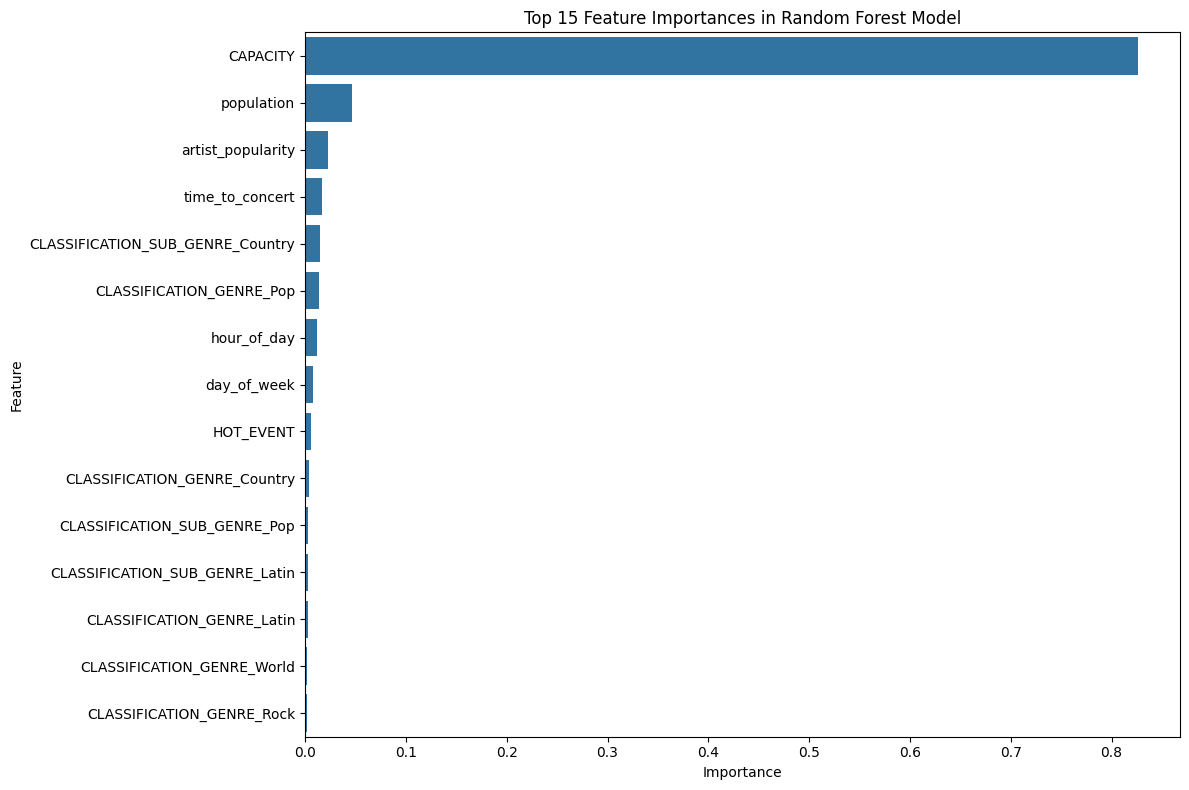

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the Random Forest model
feature_importances = rand_for_max["model"].feature_importances_
features = X.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(15)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Top 15 Feature Importances in Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


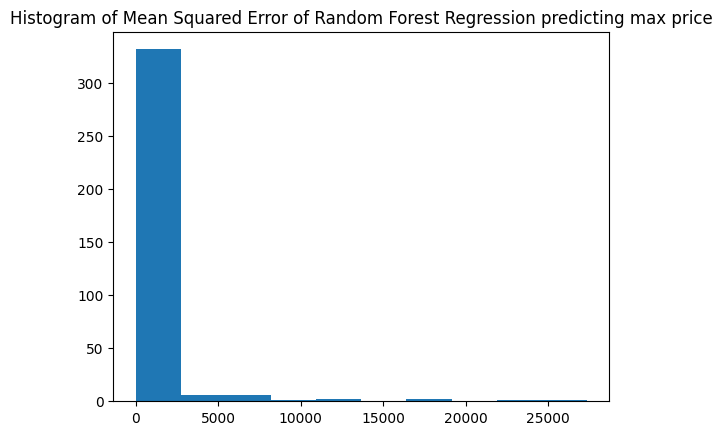

In [40]:
plt.hist(rand_for_max["squared_err_arr"])
plt.title("Histogram of Mean Squared Error of Random Forest Regression predicting max price")
plt.show()

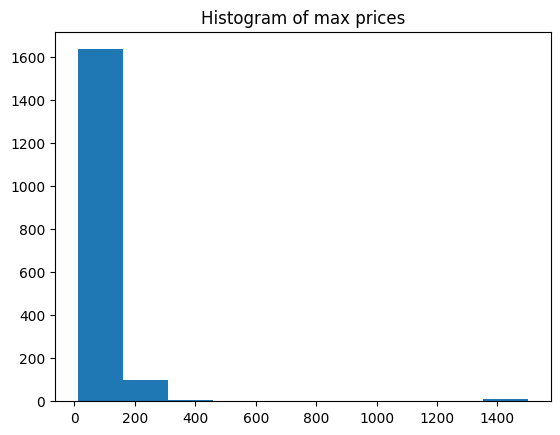

In [41]:
plt.hist(max_y)
plt.title("Histogram of max prices")
plt.show()

These histograms show how the Mean Squared Error is skewed higher because of some concerts with extreme outlier prices, which likely contributes to the a slightly higher MSE of the random forest model, even though it has a high r^2 value.